#### Imports

In [1]:
from helpers import calc_fuzziness, load_mnist, test_loss_func, generate_results_df, calc_error_rates, generate_distance_metrics, calc_efficiency_metrics, savefig, load_usps_hdf5
from model import FFNN, FFNNAdapter

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
np.random.seed(500)
import pandas as pd
import pickle
import seaborn as sns
sns.set(context='notebook', style="whitegrid", font='serif', font_scale=1, color_codes=True, rc=None)
from sklearn.model_selection import train_test_split
import time
import os

import nonconformist
from nonconformist.acp import AggregatedCp, RandomSubSampler
from nonconformist.icp import IcpClassifier
from nonconformist.nc import  ClassifierNc

In [2]:
colors = sns.color_palette()

# USPS-10 results

In [3]:
IS_SAVE_GRAPHS = False

DATASET = "USPS-10"
N_CLASS = 10

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [4]:
_, _, _, y_test = load_usps_hdf5()

In [5]:
df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))
df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [6]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,5.119470e-23,0.575984,0.30,FFNN,2.993150,0.149515,0.113599,USPS-10,./pickles/USPS-10 intermediate results/0 - FFN...,1.165521
1,1,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,4.573544e-14,0.659193,0.25,FFNN,2.166807,0.138143,0.088303,USPS-10,./pickles/USPS-10 intermediate results/1 - FFN...,0.754360
2,2,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,3.834970e-12,0.701545,0.20,FFNN,0.930545,0.325037,0.081845,USPS-10,./pickles/USPS-10 intermediate results/2 - FFN...,0.834828
3,3,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,2.947199e-33,0.691081,0.15,FFNN,1.123382,0.122115,0.136872,USPS-10,./pickles/USPS-10 intermediate results/3 - FFN...,1.642501
4,4,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,1.678912e-26,0.708022,0.15,FFNN,0.769155,0.131340,0.122024,USPS-10,./pickles/USPS-10 intermediate results/4 - FFN...,1.157200
5,5,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,7.461195e-19,0.734429,0.15,FFNN,0.761893,0.124080,0.102618,USPS-10,./pickles/USPS-10 intermediate results/5 - FFN...,0.859741
6,6,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,5.754061e-19,0.738416,0.15,FFNN,0.746705,0.128819,0.102931,USPS-10,./pickles/USPS-10 intermediate results/6 - FFN...,0.900399
7,7,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,6.175840e-20,0.744395,0.15,FFNN,0.703139,0.128990,0.105583,USPS-10,./pickles/USPS-10 intermediate results/7 - FFN...,0.842651
8,8,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,3.148254e-14,0.748381,0.15,FFNN,0.934618,0.312274,0.088826,USPS-10,./pickles/USPS-10 intermediate results/8 - FFN...,0.843946
9,9,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,9.036637e-23,0.747882,0.10,FFNN,0.709575,0.142967,0.112978,USPS-10,./pickles/USPS-10 intermediate results/9 - FFN...,1.125311


# Empirical results

### Calibration

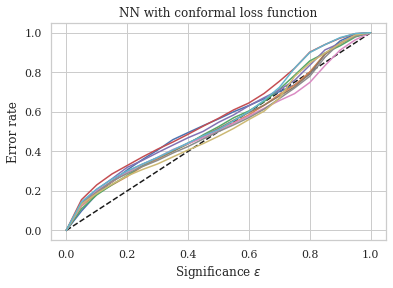

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn.index:
    filepath = df_ffnn.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

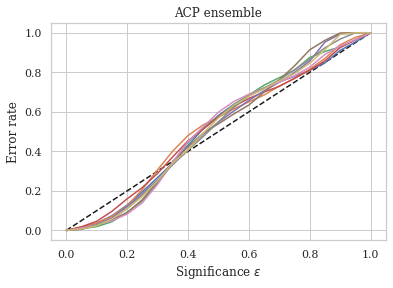

In [8]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()

# USPS-2 results

In [9]:
IS_SAVE_GRAPHS = False

DATASET = "USPS-2"
N_CLASS = 2

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [10]:
_, _, _, y_test = load_usps_hdf5()
test_mask = np.logical_or(y_test==0, y_test==1)
y_test = y_test[test_mask]

In [11]:
df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))
df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [12]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,1,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000008,0.951846,0.05,FFNN,1.259021,0.131185,0.099682,USPS-2,./pickles/USPS-2 intermediate results/1 - FFNN...,0.704334
1,2,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000006,0.963082,0.05,FFNN,0.792566,0.619672,0.100771,USPS-2,./pickles/USPS-2 intermediate results/2 - FFNN...,0.697913
2,3,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000009,0.966292,0.05,FFNN,2.454183,0.272054,0.099154,USPS-2,./pickles/USPS-2 intermediate results/3 - FFNN...,0.676404
3,4,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000012,0.964687,0.05,FFNN,2.422129,0.488202,0.097772,USPS-2,./pickles/USPS-2 intermediate results/4 - FFNN...,0.692616
4,5,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000103,0.966292,0.05,FFNN,1.682471,0.147721,0.088679,USPS-2,./pickles/USPS-2 intermediate results/5 - FFNN...,0.760353
5,6,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000030,0.967897,0.05,FFNN,1.134680,0.145337,0.094132,USPS-2,./pickles/USPS-2 intermediate results/6 - FFNN...,0.711717
6,7,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000005,0.972713,0.05,FFNN,0.961507,0.270589,0.101590,USPS-2,./pickles/USPS-2 intermediate results/7 - FFNN...,0.800642
7,8,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000003,0.969502,0.05,FFNN,1.481459,0.135794,0.102892,USPS-2,./pickles/USPS-2 intermediate results/8 - FFNN...,0.799839
8,9,FFNN conformal loss l2-4 hw-0.25 hd-0.125 v-1 ...,0.000001,0.969502,0.05,FFNN,0.702249,0.142372,0.106231,USPS-2,./pickles/USPS-2 intermediate results/9 - FFNN...,0.840770


# Empirical results

### Calibration

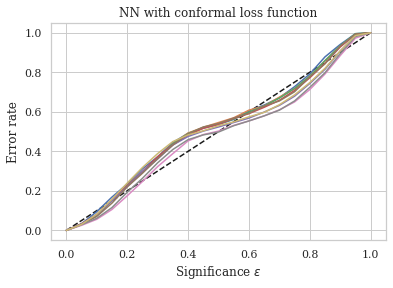

In [13]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn.index:
    filepath = df_ffnn.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

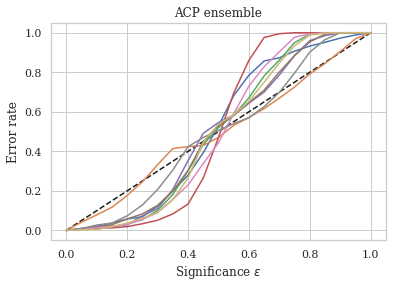

In [14]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()

# BANK results

In [15]:
IS_SAVE_GRAPHS = False

DATASET = "BANK"
N_CLASS = 2

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [16]:
df = pd.read_csv("./../data/bank-additional-full.csv",delimiter=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [17]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [18]:
_, _, _, y_test = train_test_split(df, [0 if y=='no' else 1 for y in df.y], test_size=0.33, shuffle=True, stratify=df.y, random_state=42)
y_test = np.array(y_test)

In [19]:
df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))
df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [20]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.829123e-124,0.915839,0.05,FFNN,2.716660,0.322800,0.102366,BANK,./pickles/BANK intermediate results/0 - FFNN c...,0.848621
1,1,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,5.144666e-162,0.896638,0.05,FFNN,1.675820,0.478509,0.116799,BANK,./pickles/BANK intermediate results/1 - FFNN c...,1.055801
2,2,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.476492e-171,0.892812,0.05,FFNN,1.691521,0.346753,0.120187,BANK,./pickles/BANK intermediate results/2 - FFNN c...,1.166520
3,3,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.012340e-184,0.881557,0.05,FFNN,1.641975,0.309011,0.124709,BANK,./pickles/BANK intermediate results/3 - FFNN c...,1.220665
4,4,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,4.205376e-192,0.878393,0.05,FFNN,1.779454,0.657198,0.127173,BANK,./pickles/BANK intermediate results/4 - FFNN c...,1.277091
5,5,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.749800e-197,0.872214,0.05,FFNN,1.616346,0.395507,0.128940,BANK,./pickles/BANK intermediate results/5 - FFNN c...,1.279283
6,6,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.864494e-206,0.863974,0.05,FFNN,2.541421,0.275055,0.131831,BANK,./pickles/BANK intermediate results/6 - FFNN c...,1.372508
7,7,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,9.137362e-210,0.864048,0.05,FFNN,1.690164,0.513008,0.132882,BANK,./pickles/BANK intermediate results/7 - FFNN c...,1.460127
8,8,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,8.777956e-214,0.862871,0.05,FFNN,1.622078,0.309107,0.134146,BANK,./pickles/BANK intermediate results/8 - FFNN c...,1.455124
9,9,FFNN conformal loss l2-1 hw-0.25 hd-0.125 v-1 ...,1.225263e-214,0.867064,0.05,FFNN,1.774423,0.311381,0.134414,BANK,./pickles/BANK intermediate results/9 - FFNN c...,1.455933


# Empirical results

### Calibration

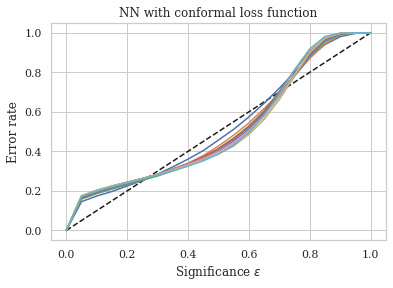

In [21]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn.index:
    filepath = df_ffnn.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

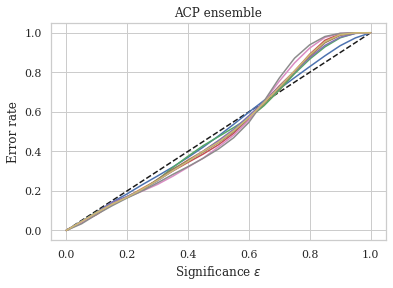

In [22]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()

# WINE results

In [23]:
IS_SAVE_GRAPHS = False

DATASET = "WINE-COLOUR"
N_CLASS = 2

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [24]:
df = pd.read_csv("./../data/winequality-red.csv",delimiter=";")
nr_red = len(df)
print(nr_red)
df = pd.concat((df, pd.read_csv("./../data/winequality-white.csv",delimiter=";")))

df['is_red'] = [1]*nr_red + [0]*(len(df)-nr_red)

df

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [25]:
df['is_red'].value_counts()

0    4898
1    1599
Name: is_red, dtype: int64

In [26]:
_, _, _, y_test = train_test_split(df, df['is_red'], test_size=0.33, shuffle=True, stratify=df['is_red'], random_state=42)
y_test = np.array(y_test)

In [27]:
df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))
df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [28]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,2.886714e-24,0.863869,0.05,FFNN,1.774672,0.353905,0.112887,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/0 -...,0.888578
1,1,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,1.572192e-27,0.927739,0.05,FFNN,0.626138,0.168173,0.120348,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/1 -...,1.031469
2,2,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,1.717979e-19,0.924476,0.05,FFNN,0.670708,0.200122,0.100973,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/2 -...,0.963869
3,3,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,9.611246e-26,0.945921,0.05,FFNN,0.582271,0.193218,0.116325,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/3 -...,0.958508
4,4,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,1.268168e-15,0.952914,0.05,FFNN,0.673012,0.150799,0.090162,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/4 -...,0.850583
5,5,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,2.974046e-09,0.953846,0.05,FFNN,0.622114,0.155475,0.068724,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/5 -...,0.692075
6,6,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,3.044151e-07,0.957110,0.05,FFNN,0.706677,0.231759,0.060392,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/6 -...,0.481585
7,7,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,4.450381e-12,0.956643,0.05,FFNN,0.624151,0.155470,0.078956,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/7 -...,0.762005
8,8,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,5.835908e-19,0.953380,0.05,FFNN,0.750282,0.165995,0.099558,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/8 -...,0.996970
9,9,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,5.658528e-05,0.953380,0.05,FFNN,0.811956,0.294026,0.049320,WINE-COLOUR,./pickles/WINE-COLOUR intermediate results/9 -...,0.387413


# Empirical results

### Calibration

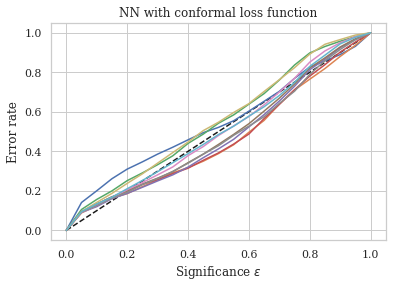

In [29]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn.index:
    filepath = df_ffnn.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

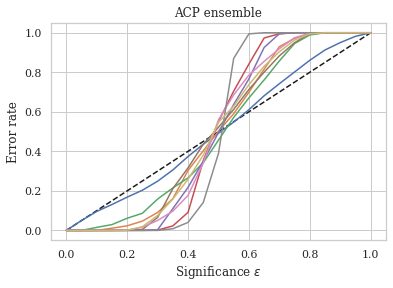

In [30]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()

# MSHRM results

In [31]:
IS_SAVE_GRAPHS = False

DATASET = "MUSHROOM"
N_CLASS = 2

SAVE_DIR = "./pickles/{} intermediate results".format(DATASET)
SAVE_FILE_FFNN = "./pickles/FFNN_{}_results_df.pickle".format(DATASET)
SAVE_FILE_ACP = "./pickles/ACP_{}_results_df.pickle".format(DATASET)
GRAPH_PATH = "./graphs/{}".format(DATASET)+"-{}.png"

EPSILON = np.arange(0, 1.05, 0.05)

## Load the data

In [32]:
df = pd.read_csv("./../data/mushroom_dataset-secondary_data.csv",delimiter=";")
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


In [33]:
df['class'].value_counts()

p    33888
e    27181
Name: class, dtype: int64

In [34]:
_, _, _, y_test = train_test_split(df, [0 if y=='e' else 1 for y in df['class']], test_size=0.33, shuffle=True, stratify=df['class'], random_state=42)
y_test = np.array(y_test)

In [35]:
df_ffnn = pickle.load(open(SAVE_FILE_FFNN, 'rb'))
df_acp = pickle.load(open(SAVE_FILE_ACP, 'rb'))

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [36]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath,abs_calib_distance
0,0,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,1.350882e-28,0.891282,0.05,FFNN,3.182891,0.466502,0.040101,MUSHROOM,./pickles/MUSHROOM intermediate results/0 - FF...,0.328562
1,1,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,1.203995e-53,0.920508,0.05,FFNN,3.014563,0.550852,0.055113,MUSHROOM,./pickles/MUSHROOM intermediate results/1 - FF...,0.388950
2,2,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,3.756868e-66,0.904580,0.05,FFNN,2.167211,0.623297,0.061243,MUSHROOM,./pickles/MUSHROOM intermediate results/2 - FF...,0.571940
3,3,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,1.621201e-52,0.904878,0.05,FFNN,2.112275,0.430225,0.054525,MUSHROOM,./pickles/MUSHROOM intermediate results/3 - FF...,0.486925
4,4,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,7.859850e-44,0.906763,0.05,FFNN,1.943794,0.459220,0.049774,MUSHROOM,./pickles/MUSHROOM intermediate results/4 - FF...,0.474594
5,5,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,2.324620e-48,0.902347,0.05,FFNN,2.275184,0.452198,0.052306,MUSHROOM,./pickles/MUSHROOM intermediate results/5 - FF...,0.434263
6,6,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,7.111998e-36,0.910038,0.05,FFNN,1.928690,0.466497,0.044983,MUSHROOM,./pickles/MUSHROOM intermediate results/6 - FF...,0.503091
7,7,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,5.677491e-43,0.906416,0.05,FFNN,2.371984,0.496456,0.049280,MUSHROOM,./pickles/MUSHROOM intermediate results/7 - FF...,0.445571
8,8,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,1.279398e-58,0.906813,0.05,FFNN,3.874850,0.674178,0.057629,MUSHROOM,./pickles/MUSHROOM intermediate results/8 - FF...,0.640078
9,9,FFNN conformal loss l2-3 hw-0.25 hd-0.125 v-1 ...,3.339674e-46,0.904183,0.05,FFNN,2.446186,0.692126,0.051116,MUSHROOM,./pickles/MUSHROOM intermediate results/9 - FF...,0.519972


# Empirical results

### Calibration

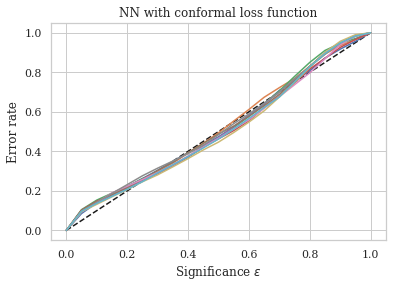

In [37]:
fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn.index:
    filepath = df_ffnn.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("NN_calibration_curve"))


plt.title("NN with conformal loss function")

plt.show()

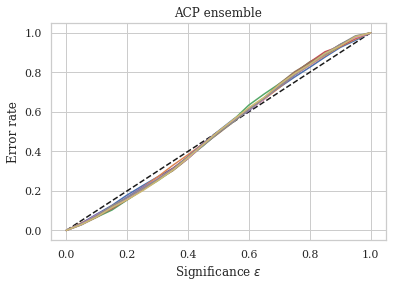

In [38]:
fig = plt.figure(figsize=(6, 4))

plt.plot([0, 1], [0, 1], 'k--')

for i in range(2, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err)#, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
# plt.legend(title="Nr estimators")

if IS_SAVE_GRAPHS: savefig(fig, GRAPH_PATH.format("ACP_calibration_curve"))

plt.title("ACP ensemble")
plt.show()